In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Part 1: Adjacency QUBO

The cell below defines the matrix that imposes the adjacency constraint on the grid, i.e. the minimum is the case where no two squares one space away from each other in any direction are activated at the same time. This is done by looping over pairs of locations on an $n$ by $n$ grid and setting the corresponding matrix element to one if they are not the same coordinate and neither of their i,j positions differs by two or more.

In [2]:
def adjacency_qubo(grid_size):
    temp = []
    pairs = [(r,c) for r in range(grid_size) for c in range(grid_size)]
    for element1 in pairs:
        for element2 in pairs:
            r1, c1, r2, c2 = element1[0], element1[1], element2[0], element2[1]
            if r1==r2 and c1==c2:
                temp.append(0)
            elif abs(r1-r2)>=2 or abs(c1-c2)>=2:
                temp.append(0)
            else:
                temp.append(1)
    return np.array([temp]).reshape((grid_size**2, grid_size**2))

# Part 2: Region QUBO

The general way of forming the row and column QUBOs is to use the regional QUBO, which effectively imposes a 1-of-n restriction on the grid based on regional data. This construction can be applied to create subqubos for the other three puzzle restrictions. An additional example of forming the row/column matrices directly is shown as an addendum of this notebook. The regional logic is simple. When regional data is passed into the function, it loops over pairs of variables and uses the regional data to determine if they are both in the same region. If they are both in the same region, the corresponding matrix component is set equal to one. An element cannot be adjacent with itself, and at the end $1$ is subtracted as part of the constraint so that one variable is activated in each region. See the explanation for more details on this construction.

The algebraic representation of our regional subqubo is the following:




\begin{align}
\sum_{i=1}^{n} \left(\sum_{k \in R_{i}}x_k - 1\right)^{2} = \sum_{i=1}^{n} \left[ \left( \sum_{k \in {R_i}}x_{k}\right)^{2} -2\sum_{k \in R_{i}}x_{k} + 1 \right]
\end{align}





Since all the variables are binary, we have $x_{k}^{2} = x_{k}$ so after cancellation, the expression has 3 terms: the constant term, the linear term, and the interaction term, which is composed of the pairwise sums of all variables in the same region. Constructing this quadratic term is what the bulk of the function region QUBO does by looping over pairs of variables and giving the matrix a coefficient of 1 if they form a regional pair. The final subtraction step comes from the fact that the linear term is simply the sum of all the variables in the vector, a sum which can be easily expressed by $x^{T}Ix$. Currently, since the goal is minimization, the constant term is being ignored, but it can be put back in at any time as long as we are sure to do so for each subqubo we construct. Therefore, all that is needed to form the QUBO's matrix representation is to add the interaction matrix and the negative identity.

In [3]:
def region_qubo(puzzle):
    mat_size = len(puzzle)
    region_dict = {k:puzzle[k] for k in range(mat_size)}
    region_qubo = np.zeros((mat_size, mat_size))
    for i in range(mat_size):
        for j in range(mat_size):
            if i!=j and region_dict[i]==region_dict[j]:
                region_qubo[i,j]+=1
    return region_qubo - np.identity(mat_size)

The helper functions below exploit the generality of the region QUBO construction by reframing the row and column restrictions as regional data.

In [4]:
def row_as_region(grid_size):
    regions = []
    for i in range(grid_size**2):
        regions.append(i//grid_size)
    return regions

def col_as_region(grid_size):
    regions = []
    for i in range(grid_size**2):
        regions.append(i%grid_size)
    return regions

# Part 3: Making the Full QUBO

Since each subqubo is minimized if and only if its particular constraint is satisfied, the sum of the QUBOs will be minimized if and only if all of the subqubos are minimized, with the caveat that the problem must have a valid solution. Therefore the full QUBO that enforces all of the puzzle conditions is simply the sum of the subqubos.

In [5]:
def make_qubo(puzzle):
    grid_size = int(np.sqrt(len(puzzle)))
    qubo = np.zeros((grid_size**2,grid_size**2))
    qubo += region_qubo(row_as_region(grid_size))
    qubo += region_qubo(col_as_region(grid_size))
    qubo += region_qubo(puzzle)
    qubo += adjacency_qubo(grid_size)
    return qubo

# Part 4: Verifying Matrices on a 3x3 Example

The puzzle below is an example puzzle to demonstrate that the functions defined above properly represent the subqubo matrices they are supposed to represent. In fact, this example has no solution satisfying all the constraints, but the subqubo matrices can be verified by hand by a patient reader. As the grid gets larger this task becomes completely unreasonable so we use this size as our first test case.

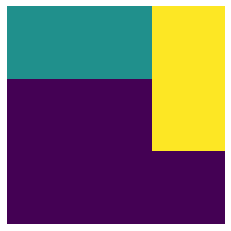

In [6]:
test_puzzle = 'AABCCBCCC'
vals = {list(set(test_puzzle))[k]: k for k in range(len(set(test_puzzle)))}

plt.imshow(np.array([vals[char] for char in test_puzzle]).reshape((3,3)))
plt.axis('off')
plt.show()

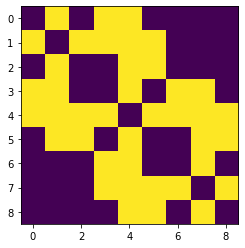

In [7]:
plt.imshow(adjacency_qubo(3))
plt.show()

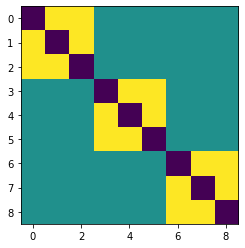

In [8]:
plt.imshow(region_qubo(row_as_region(3)))
plt.show()

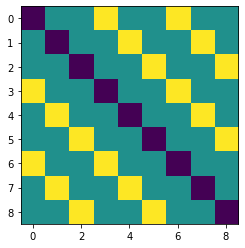

In [9]:
plt.imshow(region_qubo(col_as_region(3)))
plt.show()

In [10]:
plt.imshow(region_qubo('AABCCBCCC'))
plt.show()

Each of the 9x9 matrices above accurately represents the subqubos it is supposed to represent and can be verified by hand so we continue next by validating the whole QUBO on a computationally reasonable example.

# Part 5: Validating Results for a 4x4 Puzzle

The code below generates the solutions for a given QUBO and plots them as a filled out puzzle, with the yellow spaces representing active cells and purple representing inactive cells. Fortunately, the 4x4 case is small enough to be solved on a personal computer, but the computational space of this problem grows exponentially with the size of the grid. This exponential increase is part of the reason quantum computers are well-suited to solving these problems in theory.

In [11]:
def get_results(Q, show=False):
    # Set show=True if multiple solutions are expected
    # This parameter is good for testing that subqubos are producing satisfactory states
    mat_size = Q.shape[0]
    grid_size = int(np.sqrt(mat_size))
    states = list(product([0,1], repeat = mat_size))
    outputs = {}
    for state in states:
        x = np.array(state).reshape((mat_size,1))
        obj = x.T @ Q @ x
        outputs[state] = obj[0,0]
    minimum_value = min(outputs.values())
    solutions = [key for key in outputs if outputs[key]==minimum_value]
    if show:
        for solution in solutions:
            plt.figure(figsize=(2,2))
            plt.imshow(np.array(solution).reshape((grid_size,grid_size)))
            plt.show()
    return minimum_value, np.array(solutions[0]).reshape((grid_size,grid_size))

In [12]:
test_puzzle2 = 'AAAABBCDBBCDBBCD'
vals = {list(set(test_puzzle2))[k]: k for k in range(len(set(test_puzzle2)))}

plt.imshow(np.array([vals[char] for char in test_puzzle2]).reshape((4,4)))
plt.axis('off')
plt.show()

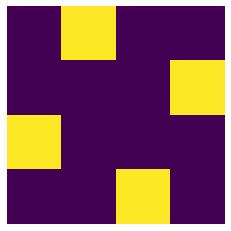

-12.0


In [13]:
Q1 = make_qubo(test_puzzle2)
min2, solution2 = get_results(Q1)
plt.imshow(solution2)
plt.axis('off')
plt.show()
print(min2)

One can easily see that this configuration solves the puzzle as desired by satisfying all the constraints. Anyone interested should consider convincing themself that having a minimum of -12 is an immediate indication that we have satisfied our 3 1-of-4 restraints and not violated any single state penalty.

# Part 6: A Real Example

The cells below use a real 8x8 Star Battle puzzle as an example. First, the puzzle is shown as it would appear to us. Then make_qubo is called to form the matrix that defines this QUBO. Finding the length 64 vector that minimizes the quadratic form of this matrix is an extremely difficult task classically; however, this problem is well-suited to quantum hardware.

In [14]:
example_puzzle = 'AABCDEEEAABCDDDDAACCDDDDAAACCDDDFFFFGGDDFFFFGGDDHHFFHHHHHHHHHHHH'

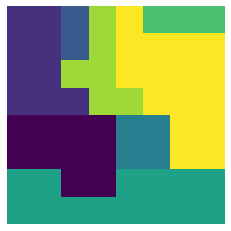

In [15]:
vals = {list(set(example_puzzle))[k]: k for k in range(len(set(example_puzzle)))}
example_array = np.array([vals[char] for char in example_puzzle]).reshape((8,8))
plt.imshow(example_array)
plt.axis('off')
plt.show()

In [16]:
Q = make_qubo(example_puzzle)

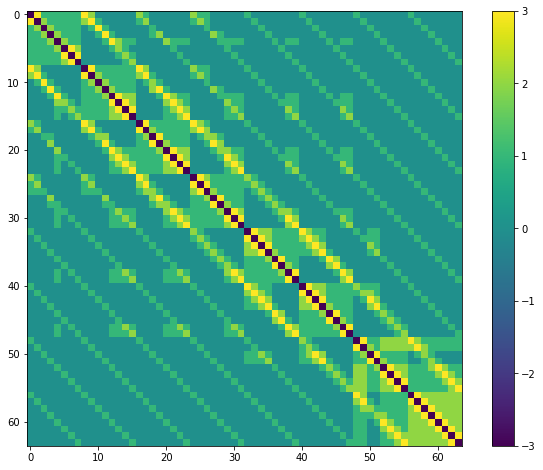

In [17]:
plt.figure(figsize=(11,8))
plt.imshow(Q)
plt.colorbar()
plt.show()

# Part 7: Solving The Full Puzzle

To get the final solution, we use the qcore part of a package called Qatalyst, which can solve QUBOs using quantum hardware or a powerful classical simulator depending on the function's argument. Note that this cell will not run for the standard user because it relies on having a unique token. Nevertheless, the output is the key feature in this process. For completion, we show the puzzle once again, the solution we get from Qatalyst, and an image of the official solution. One can verify that the output and official solution are the same. Moreover, the readers can check for themselves that each of the constraints are satisfied.

In [18]:
from qatalyst import qcore

url = 'https://api.qci-prod.com'
resp = qcore.sample_qubo(Q, url=url)

Checking validity of objective function... 
Upload progress [====================] | 100.0% | Est. remaining (sec): 0.0
Job started with JobID: 603959f2cdd44cbed746af52.

Fri Feb 26 13:29:31 2021 | Problem started

Update: CSAMPLE job starting
Fri Feb 26 13:29:34 2021 | Checking again in 3 seconds...
Problem COMPLETE, returning solution.



In [19]:
import matplotlib.image as mpig
img1 = mpig.imread('puzzle_solution1.png')

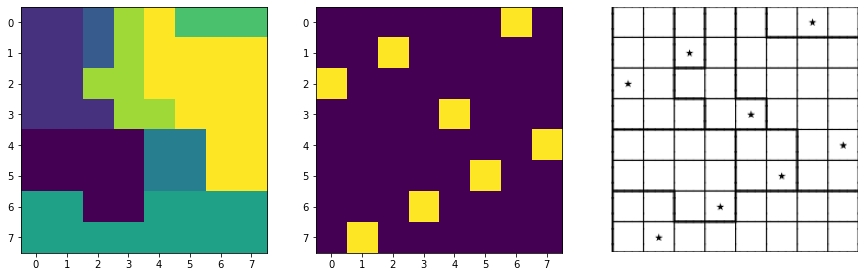

In [20]:
solution = resp.samples[0]
puzzle_solution = np.reshape(solution,(8,8))
fig, ax = plt.subplots(1,3, figsize=(15,11))
ax[0].imshow(example_array)
ax[1].imshow(puzzle_solution)
ax[2].imshow(img1)
plt.axis('off')
plt.show()

# Addendum: Row and Column Matrices

One way to enforce the row and column restrictions as QUBOs is to create the row QUBO directly and use it to create the column QUBO through a special transformation. The two functions in the cell below transition the description of any given variable between its position on the $n$ by $n$ puzzle grid and its corresponding representation as an $n^{2}$ vector. This will come in handy when changing the row restriction to a column restriction by transposing the variable positions in the grid form.

In [21]:
def line_to_grid(k, grid_size):
    return k//grid_size, k%grid_size
def grid_to_line(i,j,grid_size):
    return grid_size*i +j

print(
    [grid_to_line(i,j,8) for i in range(8) for j in range(8)]==list(range(8**2)),
    
    [line_to_grid(k,8) for k in range(8**2)]==[(i,j) for i in range(8) for j in range(8)]
)

True True


In [22]:
def row_qubo(grid_size):
    qubo = np.zeros((grid_size**2, grid_size**2))
    single_row = np.ones((grid_size, grid_size)) - 2*np.identity(grid_size)
    for row_block in range(grid_size):
        for col_block in range(grid_size):
            if row_block == col_block:
                row_start = row_block*grid_size
                row_stop = (row_block+1)*grid_size
                col_start = col_block*grid_size
                col_stop = (col_block+1)*grid_size
                qubo[row_start:row_stop, col_start:col_stop] = single_row
    return qubo

The way it is defined below, the QUBO enforcing the column restriction uses the fact that in the $n$ by $n$ grid, the row restriction is the same as the column restriction for the grid where the rows and columns have been swapped. Therefore, to get the corresponding column matrix from the row matrix, simply loop over the rows and columns of the matrix, translate the matrix coordinates to the grid coordinates, swap row and column indices, and transform it back into the matrix coordinate. In this way you create a matrix that corresponds to the row restriction on the transpose of the original grid.

In [23]:
def col_qubo(grid_size):
    row_matrix = row_qubo(grid_size)
    col_qubo = np.zeros((grid_size**2, grid_size**2))
    for k1 in range(grid_size**2):
        for k2 in range(grid_size**2):
            i1,j1 = line_to_grid(k1, grid_size)
            i2,j2 = line_to_grid(k2, grid_size)
            k1_trans = grid_to_line(j1,i1, grid_size)
            k2_trans = grid_to_line(j2,i2, grid_size)
            col_qubo[k1_trans, k2_trans] += row_matrix[k1, k2]
    return col_qubo

Lastly, we show the row and column subqubos as matrices to see that they are the same as those generated originally by the regional construction.

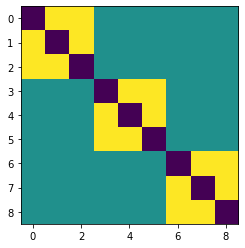

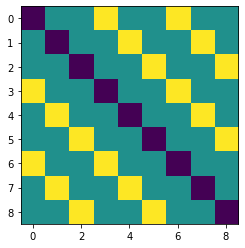

In [24]:
plt.figure()
plt.imshow(row_qubo(3))
plt.figure()
plt.imshow(col_qubo(3))
plt.show()